In [44]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import japanize_matplotlib
from glob import glob
from pathlib import Path

from consts import DATASET_ROOT, DATASET_PARENT_ROOT, CHECKPOINTS_ROOT
from utils import Range, ColorRange, filter_blue, focus_yellow, to_pil, run_focusing_yellow, COLOR_RANGE, draw_from_binary_mask, draw_bbox, get_weak_reflection_parts, combine_images

-9rmANfKvg


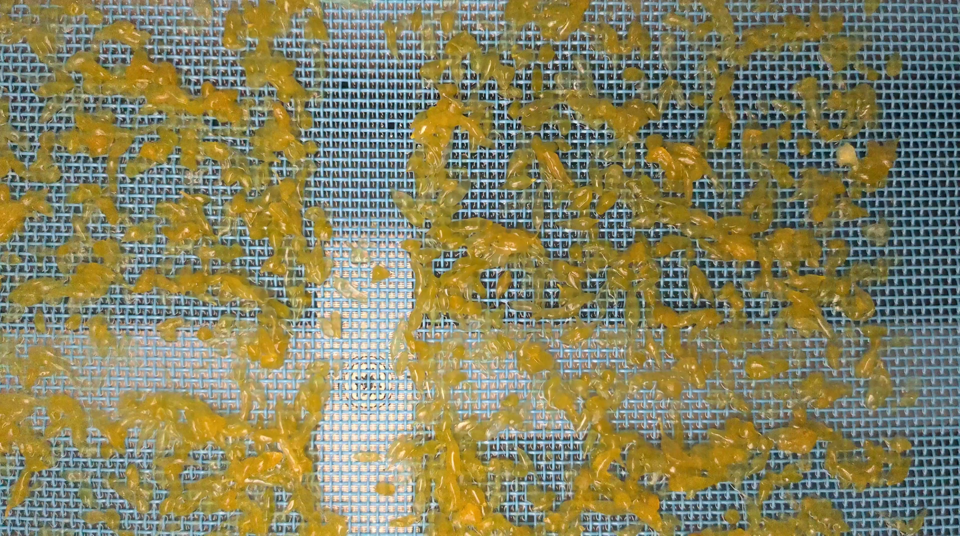

In [45]:
stems = [Path(p).stem for p in glob(f"{DATASET_ROOT}/comp/*.png")]
MASK_ROOT = f"{DATASET_PARENT_ROOT}/label_studio_VID_20240124_163346/mask"
obj_masks = {s: cv2.imread(os.path.join(MASK_ROOT, f"{s}.png")) for s in stems}

# STEM = stems[12]
STEM = stems[3]
print(STEM)

ROOT = f"{CHECKPOINTS_ROOT}/dsrnet_s_test/20240603-165422/test/{STEM}"
# origin_image = f"comp/{STEM}.png"
origin_image_p = f"{ROOT}/m_input.png"
dsrnet_s_test_l_p = f"{ROOT}/dsrnet_s_test_l.png"
dsrnet_s_test_r_p = f"{ROOT}/dsrnet_s_test_r.png"
dsrnet_s_test_rr_p = f"{ROOT}/dsrnet_s_test_rr.png"

assert np.all([os.path.exists(p) for p in [origin_image_p, dsrnet_s_test_l_p, dsrnet_s_test_r_p, dsrnet_s_test_rr_p]])

Image.open(origin_image_p)

In [46]:
origin_image, dsrnet_s_test_l, mask, masked = get_weak_reflection_parts(
    origin_image_p, dsrnet_s_test_l_p, dsrnet_s_test_r_p, dsrnet_s_test_rr_p, obj_masks[STEM], does_draw_bbox=True
)
Image.fromarray(masked[:, :, ::-1])
before = masked[:, :, ::-1].copy()

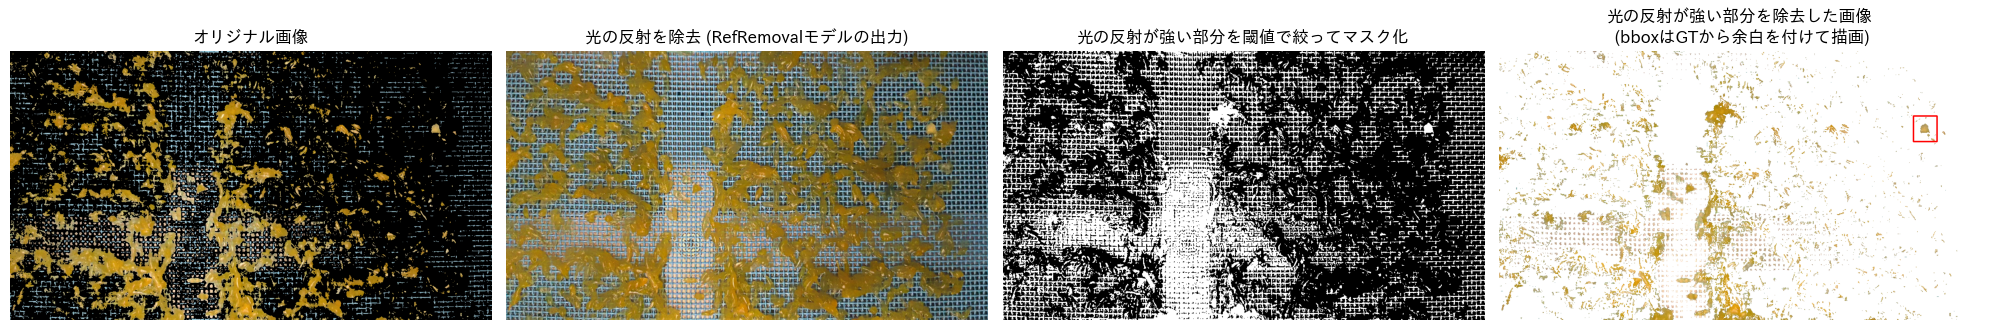

In [47]:
def display_images(original, reflection, mask, non_reflective):
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))

    axes[0].imshow(original)
    axes[0].set_title("オリジナル画像")
    axes[0].axis("off")

    axes[1].imshow(reflection, cmap="gray")
    axes[1].set_title("光の反射を除去 (RefRemovalモデルの出力)")
    axes[1].axis("off")

    axes[2].imshow(mask, cmap="gray")
    axes[2].set_title("光の反射が強い部分を閾値で絞ってマスク化")
    axes[2].axis("off")

    axes[3].imshow(non_reflective)
    axes[3].set_title("光の反射が強い部分を除去した画像\n (bboxはGTから余白を付けて描画)")
    axes[3].axis("off")

    # plt.savefig(f"{STEM}.png", bbox_inches="tight")
    plt.tight_layout()
    plt.show()


display_images(
    origin_image[:, :, ::-1],
    dsrnet_s_test_l[:, :, ::-1],
    mask,
    masked[:, :, ::-1],
)

# Experiments


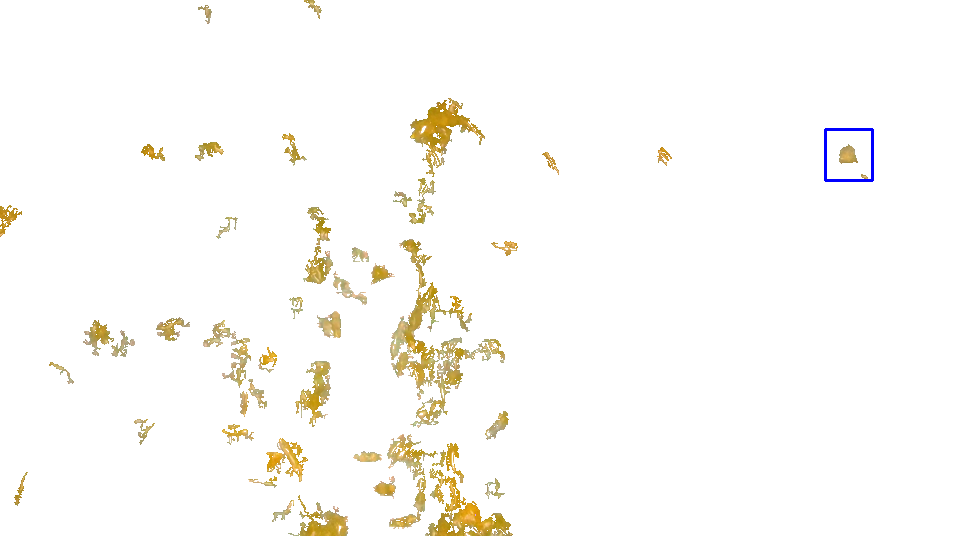

In [48]:
origin_image, dsrnet_s_test_l, mask, masked = get_weak_reflection_parts(
    origin_image_p, dsrnet_s_test_l_p, dsrnet_s_test_r_p, dsrnet_s_test_rr_p, obj_masks[STEM], does_draw_bbox=False
)

def convert_to_binary_mask(image, threshold=127):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 閾値処理によるバイナリマスクの生成
    _, binary_mask = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

    binary_mask = np.where(binary_mask == 255, 0, 255).astype(np.uint8)
    
    return binary_mask


def filter_large_components(mask, min_size):
    # ラベル付けと統計情報の取得
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=4)

    # 大きな連結成分のみを残すためのマスクを作成
    large_components_mask = np.zeros_like(mask)
    
    for i in range(1, num_labels):  # ラベル0は背景
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            large_components_mask[labels == i] = 255

    return large_components_mask

image_path = 'path_to_your_image.jpg'  # 画像ファイルのパスを指定
mask = convert_to_binary_mask(before, threshold=196)

min_size = 100
mask = filter_large_components(mask, min_size)

# display(Image.fromarray(mask))

after = np.array(Image.open(origin_image_p))
after = cv2.bitwise_and(before, before, mask=mask)
after = np.where(mask[:, :, None] == 0, 255, after).astype(np.uint8)

# draw bbox
obj_mask = cv2.resize(obj_masks[STEM], (origin_image.shape[1], origin_image.shape[0]))
obj_mask = cv2.cvtColor(obj_mask, cv2.COLOR_BGR2GRAY)
x, y, w, h = cv2.boundingRect(obj_mask)
M = 10
x, y, w, h = x - M, y - M, w + 2 * M, h + 2 * M
after = draw_bbox(after, x, y, w, h, color=(0, 0, 255), thickness=2)

Image.fromarray(after)

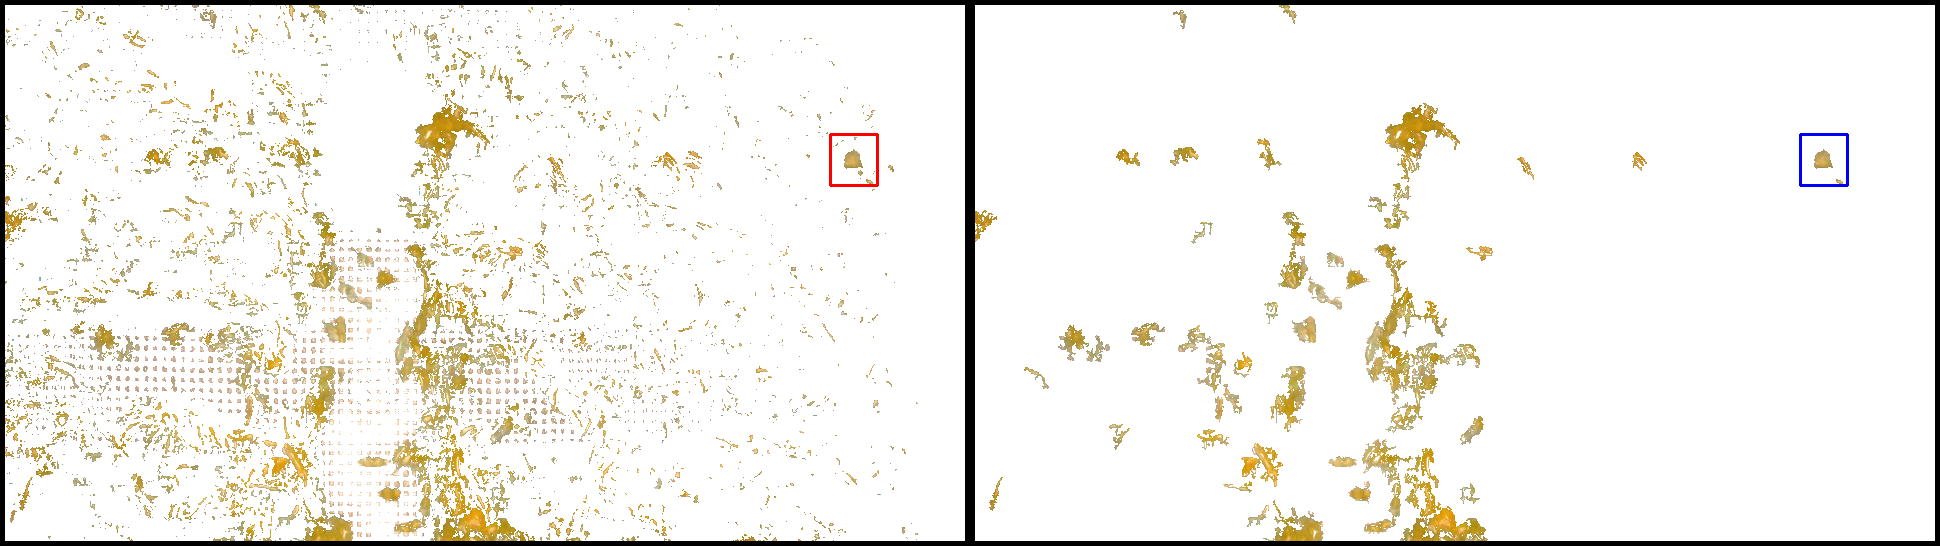

In [49]:
combine_images([before, after], rtn_pil=True)

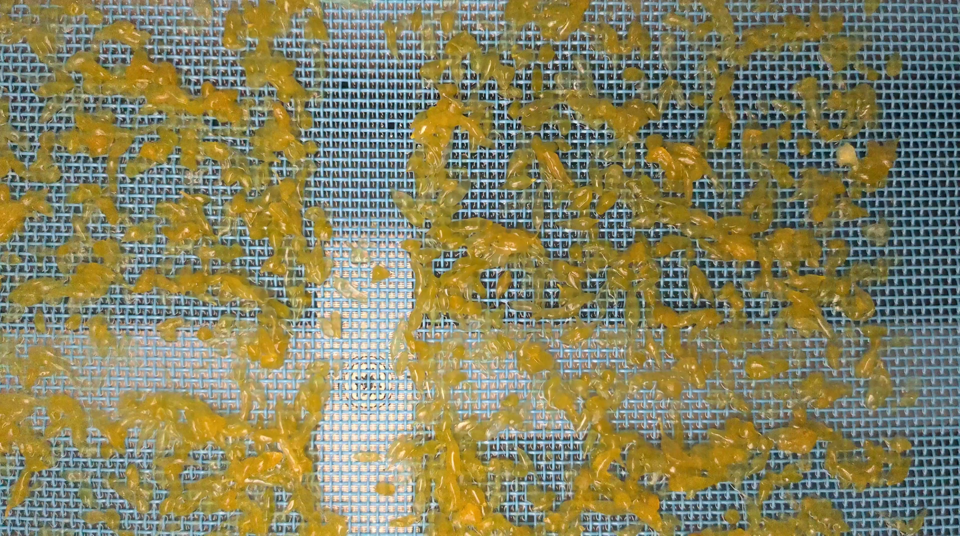

In [50]:
Image.open(origin_image_p)